In [1]:
import numpy as np
from scipy.stats import binom, norm
from scipy.optimize import minimize, Bounds
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


def pintar_histograma_int(entrada, envolvente="no"):
    """
    Esta función pinta un histograma cuando los datos de entrada son enteros, utilizando tantos bins
    como numeros diferentes componen la entrada. Está pensada para pintar distribuciones aleatorias
    de números enteros (e.g., una binomial). La variable 'envolvente' puede ser o bien 0 (en cuyo caso se ignora),
    o bien la curva de distribución de probabilidad, que se pintará junto al histograma
    """
    maximo = max(entrada) # este sera el bin superior
    minimo = min(entrada) # este sera el bis inferior

    result = [0 for i in range(minimo,maximo+1,1)]
    for i in range(len(entrada)):
        result[entrada[i]-minimo]+=1
  
    area=0
    for i in result:
        area+=i
    for i in range(len(result)):
        result[i]=result[i]/area
    plt.bar([i for i in range(minimo,maximo+1,1)], result)

    if envolvente!="no":
        minimo_envolvente = min(envolvente)
        for i in range(len(envolvente)):
            envolvente[i]=envolvente[i]-minimo_envolvente
        area=0
        for i in envolvente:
            area+=i
        for i in range(len(envolvente)):
            envolvente[i]=envolvente[i]/area

        plt.plot([i for i in range(len(envolvente))], envolvente, color='tab:orange',linewidth=5.0)

    plt.show()


def generar_numeros_any(distribucion):
    """
    Esta función genera un número entero aleatorio entre 0 y len(distribucion)-1 compatible con la distribución de 
    probabilidad introducida en 'distribucion'. Esta variable es una lista con los valores de la distribución de 
    probabilidad.
    """
    maximo = max(distribucion)
    minimo = min(distribucion)
    while 1:
        a = minimo+np.random.random()*(maximo-minimo) # genera un n aleatorio entre 0 y el maximo de la curva
        b = np.random.randint(0, len(distribucion)) # geenra un n int aleatorio entre 0 y len(distribucion)-1
        if a<distribucion[b]:
            return b
        
        
def invertir_funcion(f, y, x_ini):
    """
    Calcula el valor 'x'>x_ini t.q. f(x)=y, con una resolución EPS=1e-7. 
    """
    dx=0.1
    x=x_ini
    EPS=1e-7
    while 1:
        while cumver_interp(x)<y:
            x+=dx
        if abs(cumver_interp(x)-y)<EPS:
            break
        else:
            x-=dx
            dx/=2
    return x


def derivada2_numerica(f, x0, eps=1e-7):
    """
    Esta función calcula la derivada numérica a segundo orden para la función 'f(x)' en el punto 'x0'.
    'eps' es un parámetro opcional (si no se especifica se utiliza eps=1e-7)
    """
    return (f(x0+eps)+f(x0-eps)-2*f(x0))/eps**2
  
    
    
def dominio(func, x0, x1, xc, tol):
    """
    Esta función calcula el intervalo (x_inf, x_sup) entorno al punto 'xc' tal que el área bajo la curva encerrada
    coincida con alpha*area_total, donde 'area_total' es el área de la curva entre x0 y x1.
    """
    dx_izda = (xc-x0)/10
    dx_dcha = (x1-xc)/10
    area = integrate.quad(func, x0, xc) + integrate.quad(func, xc, x1)
    x_izda = xc
    x_dcha = xc
    
    
    while 1:
        if x_izda > x0:
            x_izda = xc-dx_izda
        if x_dcha < x1:
            x_dcha = xc+dx_dcha
    
    area_izda_new = integrate.quad(func, x_izda, xc)
    area_dcha_new = integrate.quad(func, xc, x_dcha)
    area_new = integrate.quad(func, x_izda, xc)+integrate.quad(func, xc, x_dcha)
    if area_new - area < tol:
        break
    else:
        area = area_new
        

# Modelo 0-D
El caso más sencillo de modelo que estudiamos aquí es el de una variable aleatoria $X$, la cual toma valores en el intervalo $(x_0$, $x_1)$ de acuerdo con una cierta distribución de probabilidad $P(x\vert\mathbf{a},\mathcal{H})\equiv$ probabilidad de que $X=x$ dada la hipótesis $\mathcal{H}$ (i.e., dada una cierta forma funcional), y el conjunto de $M$ parámetros $\mathbf{a}=\left(a_1,\cdots,a_M\right)$. Dada una serie de $N$ observaciones $\mathbf{x}=\left(x_1,\cdots,x_N\right)$ el objetivo del modelado es encontrar los valores de los parámetros $\mathbf{a}$ que mejor reproducen las observaciones $\mathbf{x}$.
Dada una serie de observaciones, podemos definir la probabilidad conjunta como:
\begin{equation}
\text{P}\left(\mathbf{x}\vert\mathbf{a},\mathcal{H}\right)\equiv \prod_{i=1}^{N}{\text{P}\left(x_i\vert\mathbf{a},\mathcal{H}\right)}
\end{equation}

Y la función de verosimilitud:
\begin{equation}
\text{L}_{\mathbf{x},\mathcal{H}}\left(\mathbf{a}\right)\equiv \text{P}\left(\mathbf{x}\vert\mathbf{a},\mathcal{H}\right)
\end{equation}
Como se puede ver, la forma de la función de verosimilitud está determinada por la hipótesis $\mathcal{H}$. Además, aunque depende tanto de los valores $\mathbf{a}$ como $\mathbf{x}$, la dependencia de estos últimos es paramétrica, y por lo tanto las únicas variables de la función de verosimilitud son las $M$ cantidades $\mathbf{a}$.

## Método de máxima verosimilitud
El método de máxima verosimilitud consiste en encontrar el conjunto de parámetros $\mathbf{a}$ que maximizan la función de verosimilitud $\text{L}$; por comodidad, gneralmente se maximiza el logaritmo de esta función (notar que dado que el logaritmo es una función monótonamente creciente, el valor que maximiza el argumento también maximiza su logaritmo):
\begin{equation}
    \log{\text{L}_{\mathbf{x},\mathcal{H}}\left(\mathbf{a}\right)}=\sum_{i=1}^{N}{\log{\text{P}\left(x_i\vert\mathbf{a},\mathcal{H}\right)}}
\end{equation}

### Confianza en la estimación del parámetro
La función de verosimilitud se puede utilizar junto con una interpretación bayesiana de la probabilidad para estimar los márgenes de error de los estimadores hayados. para ello utilizamos el teorema de Bayes:
\begin{equation}
\text{P}\left(\mathbf{a}\vert \mathbf{x},\mathcal{H}\right)=\frac{\text{P}\left(\mathbf{x}\vert \mathbf{a},\mathcal{H}\right)\text{P}\left(\mathbf{a}\vert \mathcal{H}\right)}{\text{P}\left(\mathbf{x}\vert \mathcal{H}\right)}
\end{equation}

Dado que la cantidad $\text{P}\left(\mathbf{x}\vert\mathcal{H}\right)$ depende de las cantidades $x_i$ (que son constantes dada una muestra $\mathbf{x}$ concreta) y no de la elección de parámetros $\mathbf{a}$, puede obviarse como una constante de normalización,
\begin{equation}
\text{P}\left(\mathbf{a}\vert \mathbf{x},\mathcal{H}\right)\propto \text{P}\left(\mathbf{x}\vert \mathbf{a},\mathcal{H}\right)\text{P}\left(\mathbf{a}\vert\mathcal{H}\right)
\end{equation}

Por otra parte, la cantidad $\text{P}\left(\mathbf{a}\vert\mathcal{H}\right)$ representa la probabilidad de que los parámetros tomen ciertos valores dada la hipótesis $\mathcal{H}$. Esta cantidad podría conocerse a raíz, por ejemplo, de argumentos físicos que impongan ciertas restricciones sobre los valores de los parámetros. Sin embargo, la opción más general es tener un desconocimiento total de los valores de estas cantidades, y por lo tanto asumir una distribución plana de los parámetros, $\text{P}\left(\mathbf{a}\vert\mathcal{H}\right)=\text{cte}$:
\begin{equation}
\text{P}\left(\mathbf{a}\vert \mathbf{x},\mathcal{H}\right)\propto \text{P}\left(\mathbf{x}\vert \mathbf{a},\mathcal{H}\right)=\text{L}_{\mathbf{x},\mathcal{H}}\left(\mathbf{a}\right)
\end{equation}

De modo que finalmente:
\begin{equation}
\text{P}\left(\mathbf{a}\vert \mathbf{x},\mathcal{H}\right)=\frac{\text{L}_{\mathbf{x},\mathcal{H}}\left(\mathbf{a}\right)}{ \int{\text{L}_{\mathbf{x},\mathcal{H}}\left(\mathbf{a}\right)\,d\mathbf{a}} } 
\end{equation}

#### Ejemplo 1: distribución de números enteros
Disponemos de una serie de $50$ muestras las cuales sospechamos que proceden de una cierta distribución binomial de $n=20$, pero parámetro $p$ desconocido. Buscamos el valor más probables de este parámetro utilizando el método de máxima verosimilitud. 

In [2]:
def verosimilitud_binomial(p):
    """
    Esta función calcula la función de verosimilitud cambiada de signo para una muestra aleatoria 
    (lista de valores) x, utilizando los parámetros p, n de una binomial. La función es la suma de los 
    logaritmos de la binomial de parámetros p, n para cada valor de x. 
    El valor de 'p' que maximiza esta función es una estimación estadística de 'p'
    por el método de máxima verosimilitud.
    """
    result = 1
    for i in muestras:
        aux = binom.pmf(i, 20, p)
        #if abs(aux) < 1e-7:
         #   aux = 1e-7
        result *= aux
    return -result


def log_verosimilitud_binomial(p):
    """
    Esta función calcula la función de verosimilitud cambiada de signo para una muestra aleatoria 
    (lista de valores) x, utilizando los parámetros p, n de una binomial. La función es la suma de los 
    logaritmos de la binomial de parámetros p, n para cada valor de x. 
    El valor de 'p' que maximiza esta función es una estimación estadística de 'p'
    por el método de máxima verosimilitud.
    """
    result = 0
    for i in muestras:
        aux = binom.pmf(i, 20, p)
        if aux<1e-7:
            aux = 1e-7
        result += np.log(aux)
    return -result

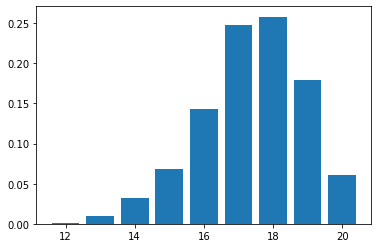

In [38]:
# MUESTRAS DE LA BINOMIAL

muestras = binom.rvs(n=20, p=0.87, size=1000)
pintar_histograma_int(muestras)

In [26]:
def func(x):
    return x

print(integrate.quad(func, 0, 1))

print(integrate.quad(verosimilitud_binomial, 0, 1))

(0.5, 5.551115123125783e-15)
(-2.3781080777927144e-41, 4.136177166346164e-41)


Curva de log-verosimilitud normalizada:


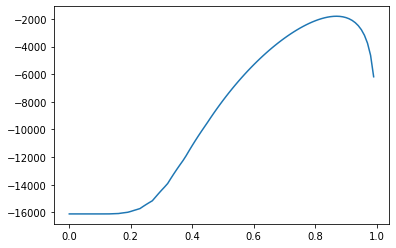

In [40]:
# DIBUJAMOS LA CURVA DE VEROSIMILITUD

x0 = 0 # valor inicial de la curva
x1 = 1 # valor final de la curva
dx = 0.01 # incremento
x_eje = [x0+i*dx for i in range(int((x1-x0)/dx))]

#def ver_norm(p, area):
 #   return verosimilitud_binomial(p)/area
#area = integrate.quad(verosimilitud_binomial, 0, 1)[0]
#print(area)
#print(integrate.quad(ver_norm, 0, 1, args=area))

#ver = np.array([ver_norm(i, area) for i in x_eje]) # forma funcional
#ver = ver-min(ver) # acotada inferiormente por 0
#ver = ver/integrate.trapz(ver, x_eje) # normalizada a una dist. de probabilidad
#ver_interp = interp1d(x_eje, ver) # interpolación de la curva de verosimilitud

logver = np.array([-log_verosimilitud_binomial(i) for i in x_eje]) # forma funcional
#logver = logver-min(logver) # acotada inferiormente por 0
#logver = logver/integrate.trapz(logver, x_eje) # normalizada a una dist. de probabilidad
#logver_interp = interp1d(x_eje, logver) # interpolación de la curva de verosimilitud

#print("Curva de verosimilitud normalizada:")
#plt.plot(x_eje, ver)
#plt.show()

print("Curva de log-verosimilitud normalizada:")
plt.plot(x_eje, logver)
plt.show()


In [41]:
# Calculamos el máximo de la cuva de verosimilitud (de hecho, el mínimo de la curva cambiada de signo).

res = minimize(log_verosimilitud_binomial, x0=0.5, bounds=Bounds(0,1)) # minimizamos la función de verosimilitud cambiada de signo para el parámetro 'p'.
print(res)

p_opt = res.x[0] # valor óptimo hallado.
print("\nparámetro 'p':")
print(p_opt)


      fun: 1799.9815867731816
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00150067])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([0.86894999])

parámetro 'p':
0.8689499935467525


Curva de verosimilitud (con 'p' máximo hallado):


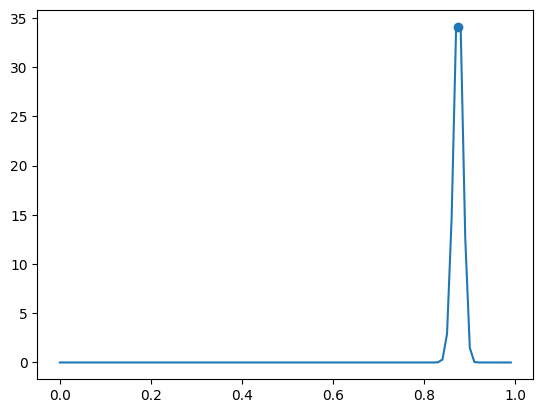

In [53]:
# Pintamos la curva de verosimilitud junto a 'p' máximo.

print("Curva de verosimilitud (con 'p' máximo hallado):")
plt.plot(x_eje, ver)
plt.scatter([p_opt],[ver_interp(p_opt)])
plt.show()

Ajuste a la binomial hallada:


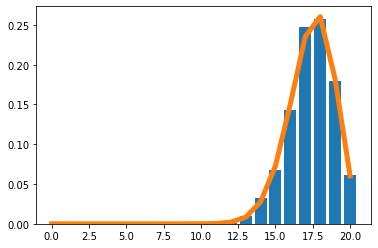

In [42]:
print("Ajuste a la binomial hallada:")
pintar_histograma_int(muestras, [binom.pmf(i, n=20, p=p_opt) for i in range(21)]) # esta función pinta simultáneamente el histograma y la curva de ajuste.

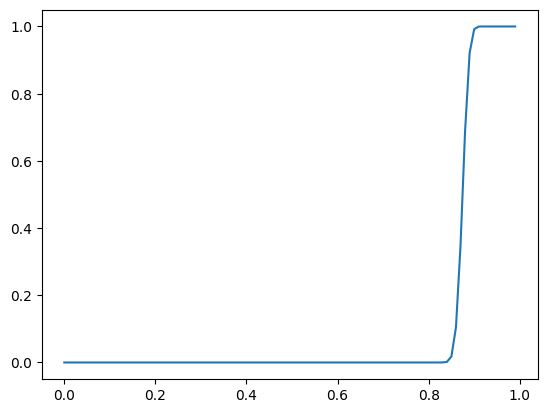

In [55]:
# CONFIANZA EN LA ESTIMACIÓN DEL PARÁMETRO

cumver = cumtrapz(ver, x_eje, initial=0) # curva de verosimilitud acumulada
cumver_interp = interp1d(x_eje,cumver) # interpolación de la curva de verosimilitud acumulada

plt.plot(x_eje, cumver)
plt.show()

In [56]:
# Usando la curva de verosimilitud como densidad de probabilidad

p_inf = invertir_funcion(ver_interp, 0.341, 0.81)
print(p_inf)

p_sup = invertir_funcion(ver_interp, 0.682, 0.81)
print(p_sup)

print(f"{0.5*(p_inf+p_sup)}+/-{0.5*(p_sup-p_inf)}")




0.8696977502107622
0.8798030143976211
0.8747503823041917+/-0.005052632093429432


In [43]:
d2 = -derivada2_numerica(log_verosimilitud_binomial, p_opt, eps=1e-7)
sigma = 1/np.sqrt(-d2)
print(f"p = {p_opt} +/- {sigma}")
print(p_opt-sigma, p_opt+sigma)

p = 0.8689499935467525 +/- 0.002350275764817988
0.8665997177819346 0.8713002693115705


# Modelo 1-D
Ahora intentamos trasladar los resultados anteriores al caso de un modelo que no consista en un único "punto" cuyo valor depende de un cierto modelo probabilístico, si no en un vector, i.e., una curva (o función uniparamétrica) aleatoria, donde la propia curva es en sí misma una entidad aleatoria, formada por puntos cada uno de los cuales es una variable aleatoria de acuerdo a un cierto modelo estocástico el cual depende de una serie de parámetros que queremos ajustar para reproducir tan bien como sea posible un conjunto de medidas (muestra, donde ahora cada elemento de la "muestra" es toda una sucesión de valores). 

#### Ejemplo
Tenemos una curva $f(x)$, la cual toma valores en un dominio $x\in(x_0,x_1)$. Disponemos de un modelo estocástico para $f$ dado por:
\begin{equation}
f(x) = mx+\xi
\end{equation}
donde $\xi$ es una variable aleatoria que se distribuye normalmente con media nula y varianza unidad, $\xi \sim \mathcal{N}(\mu=0,\sigma=1)$

In [2]:
x0 = 0 # valor inicial de la curva
x1 = 10 # valor final de la curva
dx = 0.1 # incremento

pendiente = 1

x = [x0+i*dx for i in range(int((x1-x0)/dx))]
y = [pendiente*i for i in x]

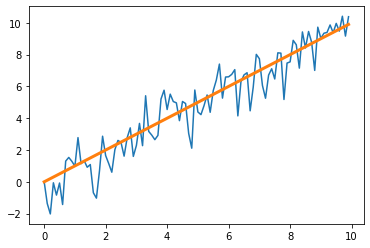


Prob. de esta muestra: -14.765983489790369


In [15]:
muestra = [pendiente*i+norm.rvs() for i in x]

#plt.scatter(x,muestra)
plt.plot(x,muestra)

plt.plot(x,y, color="tab:orange", linewidth=3.0)

plt.show()

prob=0
for i,m in enumerate(muestra):
    prob+=np.log(norm.pdf(m-x[i]*pendiente))*dx
print(f"\nProb. de esta muestra: {(prob)}")


In [22]:
## Generamos varias muestras (10?) y las guardamos en una lista, junto con sus correspondientes probs (logaritmo)
lista_muestras = [[],[]]
for i in range(10):
    muestra = [pendiente*i+norm.rvs() for i in x]
    lista_muestras[0].append(muestra)
    lista_muestras[1].append(sum([np.log(norm.pdf(m-x[j]*pendiente))*dx for j,m in enumerate(muestra)]))
    
#for i in lista_muestras[1]:
 #   print(i)
    
def prob_curva(par, curva):
    return sum([np.log(norm.pdf(c-par*x[i])) for i,c in enumerate(curva)])
    
# función de verosimilitud:
def func_ver_2d(par, muestras):
    """
    Aquí los numeros estan producidos por un modelo y=mx+xi
    """
    result=0
    for i in muestras:
        result+=prob_curva(par, i)
    return -result
    
    
m0=0
m1=2
dm=0.1
fv_x=[m0+i*dm for i in range(int((m1-m0)/dm))]
fv_y=[func_ver_2d(m, lista_muestras[0]) for m in fv_x]
    

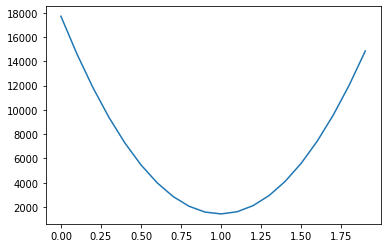

In [23]:
plt.plot(fv_x,fv_y)
plt.show()

In [24]:
# Calculamos el máximo de la cuva de verosimilitud (de hecho, el mínimo de la curva cambiada de signo).

res = minimize(func_ver_2d, x0=0.5, args=lista_muestras[0], method='Nelder-Mead', bounds=Bounds(0,2)) # minimizamos la función de verosimilitud cambiada de signo para el parámetro 'p'.
print(res)

p_opt = res.x[0] # valor óptimo hallado.
print("\nparámetro 'p':")
print(p_opt)

 final_simplex: (array([[0.99580078],
       [0.99589844]]), array([1430.49191405, 1430.49191482]))
           fun: 1430.4919140527109
       message: 'Optimization terminated successfully.'
          nfev: 32
           nit: 16
        status: 0
       success: True
             x: array([0.99580078])

parámetro 'p':
0.9958007812500012


# Simulación max. verosimilitud de datos binomiales

In [1]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

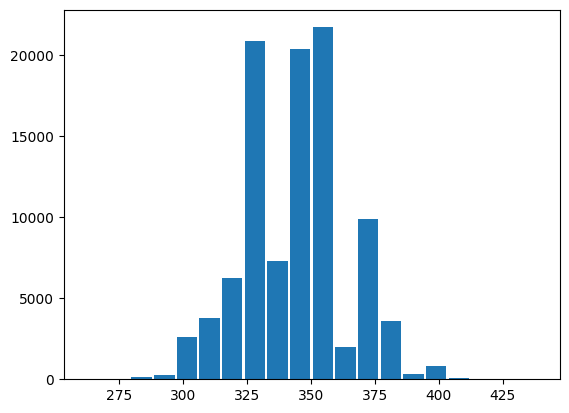

In [31]:
T = 100000
N = 1000
n = 100
p = 0.48

verosim = []
for t in range(T):
    data = st.binom.rvs(n=n,p=p,size=N)
    data_unique,data_count = np.unique(data,return_counts=True)
    data_count = data_count/N
    verosim.append(-np.log(data_count).sum()+len(data_unique)*np.log(N))

    if (t+1)%100==0:
        print(t+1,end='\r')

plt.hist(verosim,bins=20, rwidth=0.9)
plt.show()